In [ ]:
import os
import json
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [ ]:
!wget -q https://cv.snu.ac.kr/research/EDSR/benchmark.tar
!tar -xf benchmark.tar


In [ ]:
!wget -q https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip -q DIV2K_train_HR.zip



replace DIV2K_train_HR/0103.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
SCALE = 4
PATCH_SIZE = 64
DIM = 55               # papier
GAMMA = 1.0 / (2 * math.sqrt(DIM))


In [ ]:
def rgb_to_y(img):
    img = np.array(img).astype(np.float32) / 255.0
    y = 0.257 * img[...,0] + 0.504 * img[...,1] + 0.098 * img[...,2] + 16/255.
    return torch.from_numpy(y).unsqueeze(0)


In [ ]:
class DIV2KDataset(Dataset):
    def __init__(self, root, max_images=50):
        self.files = sorted(os.listdir(root))[:max_images]
        self.root = root

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.files[idx])).convert("RGB")
        w, h = img.size

        x = np.random.randint(0, w - SCALE*PATCH_SIZE)
        y = np.random.randint(0, h - SCALE*PATCH_SIZE)

        hr = img.crop((x, y, x + SCALE*PATCH_SIZE, y + SCALE*PATCH_SIZE))
        lr = hr.resize((PATCH_SIZE, PATCH_SIZE), Image.BICUBIC)

        return rgb_to_y(lr), rgb_to_y(hr)


In [ ]:
train_loader = DataLoader(
    DIV2KDataset("DIV2K_train_HR"),
    batch_size=4,
    shuffle=True
)


In [ ]:
class GRBFLinearAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gamma = 1.0 / (2 * math.sqrt(dim))
        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim, dim, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)

    def forward(self, x):
        Q = self.to_q(x)
        K = self.to_k(x)
        V = self.to_v(x)

        phi_k = torch.exp(-self.gamma * (K ** 2).sum(dim=-1, keepdim=True))

        KV = (phi_k * K).transpose(1, 2) @ V
        V_sum = (phi_k * V).sum(dim=1, keepdim=True)
        K_sum = (phi_k * K).sum(dim=1, keepdim=True)
        phi_sum = phi_k.sum(dim=1, keepdim=True)

        num = V_sum + 2 * self.gamma * (Q @ KV)
        den = phi_sum + 2 * self.gamma * (Q @ K_sum.transpose(1, 2))

        return num / (den + 1e-6)


In [ ]:
class GRBFSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.head = nn.Conv2d(1, DIM, 3, padding=1)
        self.attn = GRBFLinearAttention(DIM)
        self.body = nn.Conv2d(DIM, DIM, 3, padding=1)
        self.tail = nn.Conv2d(DIM, SCALE*SCALE, 3, padding=1)
        self.ps = nn.PixelShuffle(SCALE)

    def forward(self, x):
        f = self.head(x)
        B, C, H, W = f.shape
        f_flat = f.flatten(2).transpose(1, 2)
        f_attn = self.attn(f_flat).transpose(1, 2).view(B, C, H, W)
        out = self.body(f_attn)
        return self.ps(self.tail(out))


In [ ]:
model = GRBFSRNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.L1Loss()


In [ ]:
from tqdm import tqdm
losses = []

for epoch in tqdm(range(200)):
    model.train()
    epoch_loss = 0

    for lr, hr in train_loader:
        lr, hr = lr.to(device), hr.to(device)
        sr = model(lr)
        loss = criterion(sr, hr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1} | L1 Loss = {epoch_loss:.4f}")


  0%|          | 1/200 [00:04<15:49,  4.77s/it]

Epoch 1 | L1 Loss = 0.1117


  1%|          | 2/200 [00:10<17:01,  5.16s/it]

Epoch 2 | L1 Loss = 0.1043


  2%|▏         | 3/200 [00:14<16:13,  4.94s/it]

Epoch 3 | L1 Loss = 0.1090


  2%|▏         | 4/200 [00:20<16:35,  5.08s/it]

Epoch 4 | L1 Loss = 0.1114


  2%|▎         | 5/200 [00:24<15:56,  4.91s/it]

Epoch 5 | L1 Loss = 0.1152


  3%|▎         | 6/200 [00:29<15:30,  4.80s/it]

Epoch 6 | L1 Loss = 0.1174


  4%|▎         | 7/200 [00:34<15:55,  4.95s/it]

Epoch 7 | L1 Loss = 0.1074


  4%|▍         | 8/200 [00:39<15:31,  4.85s/it]

Epoch 8 | L1 Loss = 0.1108


  4%|▍         | 9/200 [00:44<15:56,  5.01s/it]

Epoch 9 | L1 Loss = 0.1032


  5%|▌         | 10/200 [00:49<15:32,  4.91s/it]

Epoch 10 | L1 Loss = 0.1031


  6%|▌         | 11/200 [00:54<16:13,  5.15s/it]

Epoch 11 | L1 Loss = 0.1142


  6%|▌         | 12/200 [01:02<18:15,  5.83s/it]

Epoch 12 | L1 Loss = 0.1165


  6%|▋         | 13/200 [01:07<17:16,  5.54s/it]

Epoch 13 | L1 Loss = 0.1087


  7%|▋         | 14/200 [01:12<16:47,  5.41s/it]

Epoch 14 | L1 Loss = 0.1081


  8%|▊         | 15/200 [01:17<15:59,  5.19s/it]

Epoch 15 | L1 Loss = 0.1132


  8%|▊         | 16/200 [01:22<16:01,  5.23s/it]

Epoch 16 | L1 Loss = 0.1101


  8%|▊         | 17/200 [01:27<15:26,  5.07s/it]

Epoch 17 | L1 Loss = 0.1091


  9%|▉         | 18/200 [01:32<15:15,  5.03s/it]

Epoch 18 | L1 Loss = 0.1089


 10%|▉         | 19/200 [01:37<15:13,  5.05s/it]

Epoch 19 | L1 Loss = 0.1118


 10%|█         | 20/200 [01:41<14:46,  4.92s/it]

Epoch 20 | L1 Loss = 0.1103


 10%|█         | 21/200 [01:47<15:09,  5.08s/it]

Epoch 21 | L1 Loss = 0.1108


 11%|█         | 22/200 [01:51<14:41,  4.95s/it]

Epoch 22 | L1 Loss = 0.1085


 12%|█▏        | 23/200 [01:56<14:27,  4.90s/it]

Epoch 23 | L1 Loss = 0.1051


 12%|█▏        | 24/200 [02:01<14:31,  4.95s/it]

Epoch 24 | L1 Loss = 0.1026


 12%|█▎        | 25/200 [02:06<14:07,  4.84s/it]

Epoch 25 | L1 Loss = 0.1127


 13%|█▎        | 26/200 [02:11<14:24,  4.97s/it]

Epoch 26 | L1 Loss = 0.1027


 14%|█▎        | 27/200 [02:16<14:02,  4.87s/it]

Epoch 27 | L1 Loss = 0.1043


 14%|█▍        | 28/200 [02:20<13:52,  4.84s/it]

Epoch 28 | L1 Loss = 0.1089


 14%|█▍        | 29/200 [02:26<14:06,  4.95s/it]

Epoch 29 | L1 Loss = 0.1052


 15%|█▌        | 30/200 [02:30<13:49,  4.88s/it]

Epoch 30 | L1 Loss = 0.1014


 16%|█▌        | 31/200 [02:36<14:08,  5.02s/it]

Epoch 31 | L1 Loss = 0.1028


 16%|█▌        | 32/200 [02:40<13:42,  4.90s/it]

Epoch 32 | L1 Loss = 0.1099


 16%|█▋        | 33/200 [02:45<13:35,  4.88s/it]

Epoch 33 | L1 Loss = 0.0938


 17%|█▋        | 34/200 [02:50<13:46,  4.98s/it]

Epoch 34 | L1 Loss = 0.0958


 18%|█▊        | 35/200 [02:55<13:28,  4.90s/it]

Epoch 35 | L1 Loss = 0.1040


 18%|█▊        | 36/200 [03:00<13:44,  5.03s/it]

Epoch 36 | L1 Loss = 0.1013


 18%|█▊        | 37/200 [03:05<13:21,  4.92s/it]

Epoch 37 | L1 Loss = 0.1072


 19%|█▉        | 38/200 [03:10<13:15,  4.91s/it]

Epoch 38 | L1 Loss = 0.1038


 20%|█▉        | 39/200 [03:15<13:15,  4.94s/it]

Epoch 39 | L1 Loss = 0.1075


 20%|██        | 40/200 [03:20<12:56,  4.86s/it]

Epoch 40 | L1 Loss = 0.1104


 20%|██        | 41/200 [03:25<13:12,  4.98s/it]

Epoch 41 | L1 Loss = 0.1001


 21%|██        | 42/200 [03:30<12:54,  4.90s/it]

Epoch 42 | L1 Loss = 0.1034


 22%|██▏       | 43/200 [03:35<12:50,  4.91s/it]

Epoch 43 | L1 Loss = 0.0956


 22%|██▏       | 44/200 [03:40<12:55,  4.97s/it]

Epoch 44 | L1 Loss = 0.1081


 22%|██▎       | 45/200 [03:44<12:36,  4.88s/it]

Epoch 45 | L1 Loss = 0.1056


 23%|██▎       | 46/200 [03:50<12:52,  5.02s/it]

Epoch 46 | L1 Loss = 0.0984


 24%|██▎       | 47/200 [03:54<12:30,  4.91s/it]

Epoch 47 | L1 Loss = 0.1878


 24%|██▍       | 48/200 [03:59<12:26,  4.91s/it]

Epoch 48 | L1 Loss = 0.1081


 24%|██▍       | 49/200 [04:04<12:28,  4.96s/it]

Epoch 49 | L1 Loss = 0.1121


 25%|██▌       | 50/200 [04:09<12:13,  4.89s/it]

Epoch 50 | L1 Loss = 0.1058


 26%|██▌       | 51/200 [04:14<12:27,  5.02s/it]

Epoch 51 | L1 Loss = 0.1053


 26%|██▌       | 52/200 [04:19<12:07,  4.91s/it]

Epoch 52 | L1 Loss = 0.1099


 26%|██▋       | 53/200 [04:24<12:06,  4.94s/it]

Epoch 53 | L1 Loss = 0.1008


 27%|██▋       | 54/200 [04:29<12:05,  4.97s/it]

Epoch 54 | L1 Loss = 0.1019


 28%|██▊       | 55/200 [04:34<11:48,  4.89s/it]

Epoch 55 | L1 Loss = 0.0994


 28%|██▊       | 56/200 [04:39<12:00,  5.01s/it]

Epoch 56 | L1 Loss = 0.1046


 28%|██▊       | 57/200 [04:44<11:40,  4.90s/it]

Epoch 57 | L1 Loss = 0.1092


 29%|██▉       | 58/200 [04:49<11:39,  4.93s/it]

Epoch 58 | L1 Loss = 0.1049


 30%|██▉       | 59/200 [04:54<11:34,  4.93s/it]

Epoch 59 | L1 Loss = 0.1115


 30%|███       | 60/200 [04:58<11:18,  4.84s/it]

Epoch 60 | L1 Loss = 0.1020


 30%|███       | 61/200 [05:04<11:29,  4.96s/it]

Epoch 61 | L1 Loss = 0.1010


 31%|███       | 62/200 [05:08<11:10,  4.86s/it]

Epoch 62 | L1 Loss = 0.1120


 32%|███▏      | 63/200 [05:13<11:09,  4.88s/it]

Epoch 63 | L1 Loss = 0.1033


 32%|███▏      | 64/200 [05:18<11:09,  4.92s/it]

Epoch 64 | L1 Loss = 0.1118


 32%|███▎      | 65/200 [05:23<10:53,  4.84s/it]

Epoch 65 | L1 Loss = 0.1020


 33%|███▎      | 66/200 [05:28<11:07,  4.98s/it]

Epoch 66 | L1 Loss = 0.1123


 34%|███▎      | 67/200 [05:33<10:50,  4.89s/it]

Epoch 67 | L1 Loss = 0.1013


 34%|███▍      | 68/200 [05:38<10:47,  4.90s/it]

Epoch 68 | L1 Loss = 0.0997


 34%|███▍      | 69/200 [05:43<10:46,  4.93s/it]

Epoch 69 | L1 Loss = 0.1043


 35%|███▌      | 70/200 [05:47<10:28,  4.84s/it]

Epoch 70 | L1 Loss = 0.1142


 36%|███▌      | 71/200 [05:53<10:43,  4.98s/it]

Epoch 71 | L1 Loss = 0.1143


 36%|███▌      | 72/200 [05:57<10:24,  4.88s/it]

Epoch 72 | L1 Loss = 0.1072


 36%|███▋      | 73/200 [06:02<10:20,  4.89s/it]

Epoch 73 | L1 Loss = 0.1139


 37%|███▋      | 74/200 [06:07<10:20,  4.92s/it]

Epoch 74 | L1 Loss = 0.1126


 38%|███▊      | 75/200 [06:12<10:02,  4.82s/it]

Epoch 75 | L1 Loss = 0.1035


 38%|███▊      | 76/200 [06:17<10:12,  4.94s/it]

Epoch 76 | L1 Loss = 0.1093


 38%|███▊      | 77/200 [06:22<09:55,  4.84s/it]

Epoch 77 | L1 Loss = 0.1130


 39%|███▉      | 78/200 [06:26<09:51,  4.85s/it]

Epoch 78 | L1 Loss = 0.1064


 40%|███▉      | 79/200 [06:32<09:56,  4.93s/it]

Epoch 79 | L1 Loss = 0.1029


 40%|████      | 80/200 [06:36<09:41,  4.84s/it]

Epoch 80 | L1 Loss = 0.1013


 40%|████      | 81/200 [06:42<09:53,  4.99s/it]

Epoch 81 | L1 Loss = 0.1137


 41%|████      | 82/200 [06:46<09:37,  4.89s/it]

Epoch 82 | L1 Loss = 0.1117


 42%|████▏     | 83/200 [06:51<09:32,  4.90s/it]

Epoch 83 | L1 Loss = 0.1147


 42%|████▏     | 84/200 [06:56<09:34,  4.95s/it]

Epoch 84 | L1 Loss = 0.1090


 42%|████▎     | 85/200 [07:01<09:19,  4.87s/it]

Epoch 85 | L1 Loss = 0.1145


 43%|████▎     | 86/200 [07:06<09:28,  4.98s/it]

Epoch 86 | L1 Loss = 0.1009


 44%|████▎     | 87/200 [07:11<09:11,  4.88s/it]

Epoch 87 | L1 Loss = 0.1084


 44%|████▍     | 88/200 [07:16<09:05,  4.87s/it]

Epoch 88 | L1 Loss = 0.1145


 44%|████▍     | 89/200 [07:21<09:07,  4.93s/it]

Epoch 89 | L1 Loss = 0.0838


 45%|████▌     | 90/200 [07:25<08:52,  4.84s/it]

Epoch 90 | L1 Loss = 0.0996


 46%|████▌     | 91/200 [07:31<09:02,  4.98s/it]

Epoch 91 | L1 Loss = 0.1077


 46%|████▌     | 92/200 [07:35<08:45,  4.86s/it]

Epoch 92 | L1 Loss = 0.1041


 46%|████▋     | 93/200 [07:40<08:38,  4.85s/it]

Epoch 93 | L1 Loss = 0.0976


 47%|████▋     | 94/200 [07:45<08:40,  4.91s/it]

Epoch 94 | L1 Loss = 0.0981


 48%|████▊     | 95/200 [07:50<08:26,  4.83s/it]

Epoch 95 | L1 Loss = 0.1021


 48%|████▊     | 96/200 [07:55<08:35,  4.96s/it]

Epoch 96 | L1 Loss = 0.1114


 48%|████▊     | 97/200 [08:00<08:23,  4.89s/it]

Epoch 97 | L1 Loss = 0.0935


 49%|████▉     | 98/200 [08:05<08:18,  4.88s/it]

Epoch 98 | L1 Loss = 0.1143


 50%|████▉     | 99/200 [08:10<08:19,  4.95s/it]

Epoch 99 | L1 Loss = 0.1029


 50%|█████     | 100/200 [08:14<08:06,  4.86s/it]

Epoch 100 | L1 Loss = 0.1097


 50%|█████     | 101/200 [08:20<08:14,  5.00s/it]

Epoch 101 | L1 Loss = 0.1092


 51%|█████     | 102/200 [08:24<07:59,  4.89s/it]

Epoch 102 | L1 Loss = 0.1061


 52%|█████▏    | 103/200 [08:29<07:53,  4.88s/it]

Epoch 103 | L1 Loss = 0.0970


 52%|█████▏    | 104/200 [08:34<07:54,  4.94s/it]

Epoch 104 | L1 Loss = 0.1036


 52%|█████▎    | 105/200 [08:39<07:41,  4.86s/it]

Epoch 105 | L1 Loss = 0.1049


 53%|█████▎    | 106/200 [08:44<07:49,  4.99s/it]

Epoch 106 | L1 Loss = 0.1055


 54%|█████▎    | 107/200 [08:49<07:35,  4.90s/it]

Epoch 107 | L1 Loss = 0.1074


 54%|█████▍    | 108/200 [08:54<07:31,  4.91s/it]

Epoch 108 | L1 Loss = 0.1002


 55%|█████▍    | 109/200 [08:59<07:32,  4.98s/it]

Epoch 109 | L1 Loss = 0.1123


 55%|█████▌    | 110/200 [09:04<07:19,  4.88s/it]

Epoch 110 | L1 Loss = 0.1094


 56%|█████▌    | 111/200 [09:09<07:25,  5.01s/it]

Epoch 111 | L1 Loss = 0.1009


 56%|█████▌    | 112/200 [09:14<07:11,  4.90s/it]

Epoch 112 | L1 Loss = 0.1117


 56%|█████▋    | 113/200 [09:18<07:06,  4.90s/it]

Epoch 113 | L1 Loss = 0.1083


 57%|█████▋    | 114/200 [09:23<07:03,  4.92s/it]

Epoch 114 | L1 Loss = 0.1052


 57%|█████▊    | 115/200 [09:28<06:51,  4.84s/it]

Epoch 115 | L1 Loss = 0.0989


 58%|█████▊    | 116/200 [09:33<06:58,  4.98s/it]

Epoch 116 | L1 Loss = 0.1135


 58%|█████▊    | 117/200 [09:38<06:44,  4.88s/it]

Epoch 117 | L1 Loss = 0.1125


 59%|█████▉    | 118/200 [09:43<06:40,  4.88s/it]

Epoch 118 | L1 Loss = 0.1099


 60%|█████▉    | 119/200 [09:48<06:38,  4.92s/it]

Epoch 119 | L1 Loss = 0.1002


 60%|██████    | 120/200 [09:53<06:26,  4.83s/it]

Epoch 120 | L1 Loss = 0.1044


 60%|██████    | 121/200 [09:58<06:33,  4.98s/it]

Epoch 121 | L1 Loss = 0.1058


 61%|██████    | 122/200 [10:02<06:20,  4.88s/it]

Epoch 122 | L1 Loss = 0.1086


 62%|██████▏   | 123/200 [10:07<06:15,  4.88s/it]

Epoch 123 | L1 Loss = 0.1081


 62%|██████▏   | 124/200 [10:12<06:14,  4.93s/it]

Epoch 124 | L1 Loss = 0.1042


 62%|██████▎   | 125/200 [10:17<06:02,  4.84s/it]

Epoch 125 | L1 Loss = 0.1125


 63%|██████▎   | 126/200 [10:22<06:07,  4.96s/it]

Epoch 126 | L1 Loss = 0.1032


 64%|██████▎   | 127/200 [10:27<05:55,  4.87s/it]

Epoch 127 | L1 Loss = 0.1001


 64%|██████▍   | 128/200 [10:32<05:50,  4.87s/it]

Epoch 128 | L1 Loss = 0.0996


 64%|██████▍   | 129/200 [10:37<05:49,  4.93s/it]

Epoch 129 | L1 Loss = 0.1056


 65%|██████▌   | 130/200 [10:42<05:40,  4.86s/it]

Epoch 130 | L1 Loss = 0.1034


 66%|██████▌   | 131/200 [10:47<05:43,  4.98s/it]

Epoch 131 | L1 Loss = 0.0978


 66%|██████▌   | 132/200 [10:52<05:32,  4.88s/it]

Epoch 132 | L1 Loss = 0.1091


 66%|██████▋   | 133/200 [10:56<05:28,  4.90s/it]

Epoch 133 | L1 Loss = 0.1019


 67%|██████▋   | 134/200 [11:02<05:26,  4.95s/it]

Epoch 134 | L1 Loss = 0.1085


 68%|██████▊   | 135/200 [11:06<05:15,  4.85s/it]

Epoch 135 | L1 Loss = 0.1108


 68%|██████▊   | 136/200 [11:11<05:18,  4.97s/it]

Epoch 136 | L1 Loss = 0.1092


 68%|██████▊   | 137/200 [11:16<05:07,  4.88s/it]

Epoch 137 | L1 Loss = 0.1039


 69%|██████▉   | 138/200 [11:21<05:01,  4.86s/it]

Epoch 138 | L1 Loss = 0.1064


 70%|██████▉   | 139/200 [11:26<04:59,  4.90s/it]

Epoch 139 | L1 Loss = 0.1060


 70%|███████   | 140/200 [11:31<04:49,  4.83s/it]

Epoch 140 | L1 Loss = 0.1014


 70%|███████   | 141/200 [11:36<04:51,  4.95s/it]

Epoch 141 | L1 Loss = 0.1166


 71%|███████   | 142/200 [11:40<04:41,  4.86s/it]

Epoch 142 | L1 Loss = 0.1087


 72%|███████▏  | 143/200 [11:45<04:36,  4.86s/it]

Epoch 143 | L1 Loss = 0.1090


 72%|███████▏  | 144/200 [11:50<04:36,  4.93s/it]

Epoch 144 | L1 Loss = 0.1069


 72%|███████▎  | 145/200 [11:55<04:26,  4.84s/it]

Epoch 145 | L1 Loss = 0.1042


 73%|███████▎  | 146/200 [12:00<04:28,  4.98s/it]

Epoch 146 | L1 Loss = 0.1037


 74%|███████▎  | 147/200 [12:05<04:18,  4.87s/it]

Epoch 147 | L1 Loss = 0.1017


 74%|███████▍  | 148/200 [12:10<04:12,  4.86s/it]

Epoch 148 | L1 Loss = 0.1125


 74%|███████▍  | 149/200 [12:15<04:12,  4.94s/it]

Epoch 149 | L1 Loss = 0.1088


 75%|███████▌  | 150/200 [12:20<04:02,  4.86s/it]

Epoch 150 | L1 Loss = 0.1054


 76%|███████▌  | 151/200 [12:25<04:03,  4.98s/it]

Epoch 151 | L1 Loss = 0.1106


 76%|███████▌  | 152/200 [12:29<03:54,  4.88s/it]

Epoch 152 | L1 Loss = 0.1101


 76%|███████▋  | 153/200 [12:34<03:49,  4.87s/it]

Epoch 153 | L1 Loss = 0.1047


 77%|███████▋  | 154/200 [12:39<03:46,  4.93s/it]

Epoch 154 | L1 Loss = 0.1143


 78%|███████▊  | 155/200 [12:44<03:37,  4.83s/it]

Epoch 155 | L1 Loss = 0.1055


 78%|███████▊  | 156/200 [12:49<03:37,  4.95s/it]

Epoch 156 | L1 Loss = 0.1002


 78%|███████▊  | 157/200 [12:54<03:28,  4.85s/it]

Epoch 157 | L1 Loss = 0.1027


 79%|███████▉  | 158/200 [12:59<03:22,  4.82s/it]

Epoch 158 | L1 Loss = 0.1064


 80%|███████▉  | 159/200 [13:04<03:22,  4.93s/it]

Epoch 159 | L1 Loss = 0.1057


 80%|████████  | 160/200 [13:08<03:13,  4.85s/it]

Epoch 160 | L1 Loss = 0.1099


 80%|████████  | 161/200 [13:14<03:14,  4.99s/it]

Epoch 161 | L1 Loss = 0.1098


 81%|████████  | 162/200 [13:18<03:05,  4.88s/it]

Epoch 162 | L1 Loss = 0.1050


 82%|████████▏ | 163/200 [13:23<02:58,  4.82s/it]

Epoch 163 | L1 Loss = 0.1017


 82%|████████▏ | 164/200 [13:28<02:57,  4.93s/it]

Epoch 164 | L1 Loss = 0.1105


 82%|████████▎ | 165/200 [13:33<02:49,  4.84s/it]

Epoch 165 | L1 Loss = 0.1065


 83%|████████▎ | 166/200 [13:38<02:48,  4.97s/it]

Epoch 166 | L1 Loss = 0.1050


 84%|████████▎ | 167/200 [13:43<02:40,  4.86s/it]

Epoch 167 | L1 Loss = 0.1117


 84%|████████▍ | 168/200 [13:47<02:33,  4.79s/it]

Epoch 168 | L1 Loss = 0.1112


 84%|████████▍ | 169/200 [13:53<02:33,  4.94s/it]

Epoch 169 | L1 Loss = 0.1037


 85%|████████▌ | 170/200 [13:57<02:25,  4.85s/it]

Epoch 170 | L1 Loss = 0.0983


 86%|████████▌ | 171/200 [14:03<02:24,  4.99s/it]

Epoch 171 | L1 Loss = 0.1062


 86%|████████▌ | 172/200 [14:07<02:16,  4.87s/it]

Epoch 172 | L1 Loss = 0.1087


 86%|████████▋ | 173/200 [14:12<02:09,  4.80s/it]

Epoch 173 | L1 Loss = 0.1105


 87%|████████▋ | 174/200 [14:17<02:08,  4.94s/it]

Epoch 174 | L1 Loss = 0.1046


 88%|████████▊ | 175/200 [14:22<02:01,  4.85s/it]

Epoch 175 | L1 Loss = 0.1000


 88%|████████▊ | 176/200 [14:27<01:59,  4.97s/it]

Epoch 176 | L1 Loss = 0.1104


 88%|████████▊ | 177/200 [14:32<01:52,  4.89s/it]

Epoch 177 | L1 Loss = 0.1021


 89%|████████▉ | 178/200 [14:36<01:45,  4.81s/it]

Epoch 178 | L1 Loss = 0.1038


 90%|████████▉ | 179/200 [14:42<01:43,  4.95s/it]

Epoch 179 | L1 Loss = 0.1143


 90%|█████████ | 180/200 [14:46<01:36,  4.85s/it]

Epoch 180 | L1 Loss = 0.1101


 90%|█████████ | 181/200 [14:51<01:34,  4.98s/it]

Epoch 181 | L1 Loss = 0.1067


 91%|█████████ | 182/200 [14:56<01:27,  4.88s/it]

Epoch 182 | L1 Loss = 0.1009


 92%|█████████▏| 183/200 [15:01<01:22,  4.83s/it]

Epoch 183 | L1 Loss = 0.1041


 92%|█████████▏| 184/200 [15:06<01:19,  4.96s/it]

Epoch 184 | L1 Loss = 0.0981


 92%|█████████▎| 185/200 [15:11<01:12,  4.86s/it]

Epoch 185 | L1 Loss = 0.1123


 93%|█████████▎| 186/200 [15:16<01:09,  4.98s/it]

Epoch 186 | L1 Loss = 0.1170


 94%|█████████▎| 187/200 [15:21<01:03,  4.87s/it]

Epoch 187 | L1 Loss = 0.1034


 94%|█████████▍| 188/200 [15:25<00:57,  4.79s/it]

Epoch 188 | L1 Loss = 0.1056


 94%|█████████▍| 189/200 [15:31<00:54,  4.94s/it]

Epoch 189 | L1 Loss = 0.1027


 95%|█████████▌| 190/200 [15:35<00:48,  4.85s/it]

Epoch 190 | L1 Loss = 0.1011


 96%|█████████▌| 191/200 [15:40<00:44,  4.98s/it]

Epoch 191 | L1 Loss = 0.1045


 96%|█████████▌| 192/200 [15:45<00:38,  4.87s/it]

Epoch 192 | L1 Loss = 0.1072


 96%|█████████▋| 193/200 [15:50<00:33,  4.80s/it]

Epoch 193 | L1 Loss = 0.1027


 97%|█████████▋| 194/200 [15:55<00:29,  4.95s/it]

Epoch 194 | L1 Loss = 0.1023


 98%|█████████▊| 195/200 [16:00<00:24,  4.86s/it]

Epoch 195 | L1 Loss = 0.1075


 98%|█████████▊| 196/200 [16:05<00:20,  5.00s/it]

Epoch 196 | L1 Loss = 0.0956


 98%|█████████▊| 197/200 [16:10<00:14,  4.90s/it]

Epoch 197 | L1 Loss = 0.1003


 99%|█████████▉| 198/200 [16:14<00:09,  4.81s/it]

Epoch 198 | L1 Loss = 0.0948


100%|█████████▉| 199/200 [16:20<00:04,  4.97s/it]

Epoch 199 | L1 Loss = 0.1008


100%|██████████| 200/200 [16:24<00:00,  4.92s/it]

Epoch 200 | L1 Loss = 0.1010


In [ ]:
def shave(img, scale):
    # img : numpy array (H, W)
    if scale == 1:
        return img
    return img[scale:-scale, scale:-scale]


In [ ]:
def crop_to_same_size(img1, img2):
    h = min(img1.shape[0], img2.shape[0])
    w = min(img1.shape[1], img2.shape[1])
    return img1[:h, :w], img2[:h, :w]


In [ ]:
def eval_folder(folder, scale=4, max_images=5):
    model.eval()
    psnr_list, ssim_list = [], []

    hr_dir = os.path.join(folder, "HR")
    lr_dir = os.path.join(folder, "LR_bicubic", f"X{scale}")

    files = sorted(os.listdir(hr_dir))[:max_images]

    for hr_name in files:
        hr_path = os.path.join(hr_dir, hr_name)
        lr_name = hr_name.replace(".png", f"x{scale}.png")
        lr_path = os.path.join(lr_dir, lr_name)

        hr_img = Image.open(hr_path).convert("RGB")
        lr_img = Image.open(lr_path).convert("RGB")

        lr_y = rgb_to_y(lr_img).unsqueeze(0).to(device)
        hr_y = rgb_to_y(hr_img)

        with torch.no_grad():
            sr = model(lr_y)

        sr = sr.squeeze().cpu().numpy()
        hr = hr_y.squeeze().numpy()

        # 1) Shaving
        sr = shave(sr, scale)
        hr = shave(hr, scale)

        # 2) Crop sécurisé (clé du problème)
        sr, hr = crop_to_same_size(sr, hr)

        psnr = peak_signal_noise_ratio(hr, sr, data_range=1.0)
        ssim = structural_similarity(hr, sr, data_range=1.0)

        psnr_list.append(psnr)
        ssim_list.append(ssim)

    return float(np.mean(psnr_list)), float(np.mean(ssim_list))


In [ ]:
results = {}

for name in ["Set5", "Set14", "Urban100", "B100"]:
    psnr, ssim = eval_folder(f"benchmark/{name}", scale=4, max_images=-1)
    results[name] = {"PSNR": psnr, "SSIM": ssim}
    print(f"{name}: PSNR={psnr:.2f}, SSIM={ssim:.4f}")


Set5: PSNR=15.64, SSIM=0.4562
Set14: PSNR=15.89, SSIM=0.3987
Urban100: PSNR=14.90, SSIM=0.3672
B100: PSNR=16.85, SSIM=0.3967


In [ ]:
with open("results_grbf_sr.json", "w") as f:
    json.dump(results, f, indent=2)


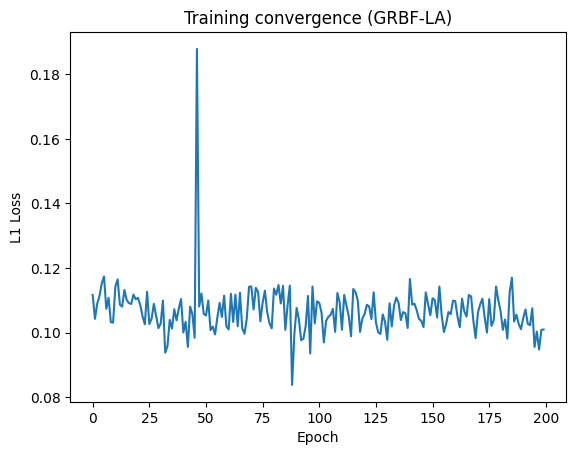

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.title("Training convergence (GRBF-LA)")
plt.show()


## une archi un peu plus avancée

In [ ]:
class GRBFBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = GRBFLinearAttention(dim)
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        B, C, H, W = x.shape
        f = x.flatten(2).transpose(1, 2)
        f = self.attn(f)
        f = self.norm(f)
        f = f.transpose(1, 2).view(B, C, H, W)
        return x + self.conv(f)


In [ ]:
class MPB(nn.Module):
    def __init__(self, dim, depth=3):
        super().__init__()
        self.blocks = nn.ModuleList([GRBFBlock(dim) for _ in range(depth)])
        self.fusion = nn.Conv2d(dim * depth, dim, 1)

    def forward(self, x):
        features = []
        out = x
        for block in self.blocks:
            out = block(out)
            features.append(out)
        return self.fusion(torch.cat(features, dim=1))


In [ ]:
class GRBFSRNet_MPB(nn.Module):
    def __init__(self, dim=55, scale=4, depth=3):
        super().__init__()
        self.head = nn.Conv2d(1, dim, 3, padding=1)
        self.mpb = MPB(dim, depth)
        self.tail = nn.Conv2d(dim, scale * scale, 3, padding=1)
        self.ps = nn.PixelShuffle(scale)

    def forward(self, x):
        x = self.head(x)
        x = self.mpb(x)
        x = self.ps(self.tail(x))
        return x


In [ ]:
DIV2KDataset(root="DIV2K_train_HR", max_images=100)


In [ ]:
class DIV2KDataset(Dataset):
    def __init__(self, root, max_images=20, patches_per_image=5):
        self.files = sorted(os.listdir(root))[:max_images]
        self.patches_per_image = patches_per_image
        self.root = root

    def __len__(self):
        return len(self.files) * self.patches_per_image


In [ ]:
from tqdm import tqdm
model = GRBFSRNet_MPB().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.L1Loss()
losses = []

for epoch in tqdm(range(50)):
    model.train()
    epoch_loss = 0

    for lr, hr in train_loader:
        lr, hr = lr.to(device), hr.to(device)
        sr = model(lr)
        loss = criterion(sr, hr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1} | L1 Loss = {epoch_loss:.4f}")


  2%|▏         | 1/50 [00:05<04:14,  5.19s/it]

Epoch 1 | L1 Loss = 0.3104


  4%|▍         | 2/50 [00:10<04:18,  5.39s/it]

Epoch 2 | L1 Loss = 0.1857


  6%|▌         | 3/50 [00:15<04:02,  5.16s/it]

Epoch 3 | L1 Loss = 0.1616


  8%|▊         | 4/50 [00:20<04:00,  5.23s/it]

Epoch 4 | L1 Loss = 0.1543


 10%|█         | 5/50 [00:26<03:53,  5.18s/it]

Epoch 5 | L1 Loss = 0.1288


 12%|█▏        | 6/50 [00:30<03:43,  5.08s/it]

Epoch 6 | L1 Loss = 0.1308


 14%|█▍        | 7/50 [00:36<03:43,  5.21s/it]

Epoch 7 | L1 Loss = 0.1241


 16%|█▌        | 8/50 [00:41<03:34,  5.10s/it]

Epoch 8 | L1 Loss = 0.1343


 18%|█▊        | 9/50 [00:46<03:34,  5.23s/it]

Epoch 9 | L1 Loss = 0.1197


 20%|██        | 10/50 [00:51<03:24,  5.12s/it]

Epoch 10 | L1 Loss = 0.1053


 22%|██▏       | 11/50 [00:56<03:18,  5.10s/it]

Epoch 11 | L1 Loss = 0.1151


 24%|██▍       | 12/50 [01:02<03:17,  5.19s/it]

Epoch 12 | L1 Loss = 0.1043


 26%|██▌       | 13/50 [01:07<03:09,  5.11s/it]

Epoch 13 | L1 Loss = 0.1089


 28%|██▊       | 14/50 [01:12<03:08,  5.24s/it]

Epoch 14 | L1 Loss = 0.0944


 30%|███       | 15/50 [01:17<02:59,  5.14s/it]

Epoch 15 | L1 Loss = 0.0858


 32%|███▏      | 16/50 [01:22<02:57,  5.23s/it]

Epoch 16 | L1 Loss = 0.0833


 34%|███▍      | 17/50 [01:27<02:50,  5.15s/it]

Epoch 17 | L1 Loss = 0.0816


 36%|███▌      | 18/50 [01:32<02:42,  5.07s/it]

Epoch 18 | L1 Loss = 0.0819


 38%|███▊      | 19/50 [01:38<02:41,  5.20s/it]

Epoch 19 | L1 Loss = 0.0722


 40%|████      | 20/50 [01:43<02:36,  5.21s/it]

Epoch 20 | L1 Loss = 0.0697


 42%|████▏     | 21/50 [01:49<02:38,  5.48s/it]

Epoch 21 | L1 Loss = 0.0672


 44%|████▍     | 22/50 [01:54<02:28,  5.31s/it]

Epoch 22 | L1 Loss = 0.0630


 46%|████▌     | 23/50 [02:00<02:25,  5.38s/it]

Epoch 23 | L1 Loss = 0.0612


 48%|████▊     | 24/50 [02:04<02:16,  5.24s/it]

Epoch 24 | L1 Loss = 0.0561


 50%|█████     | 25/50 [02:09<02:08,  5.14s/it]

Epoch 25 | L1 Loss = 0.0572


 52%|█████▏    | 26/50 [02:15<02:06,  5.27s/it]

Epoch 26 | L1 Loss = 0.0605


 54%|█████▍    | 27/50 [02:20<01:58,  5.15s/it]

Epoch 27 | L1 Loss = 0.0541


 56%|█████▌    | 28/50 [02:25<01:55,  5.25s/it]

Epoch 28 | L1 Loss = 0.0565


 58%|█████▊    | 29/50 [02:30<01:47,  5.13s/it]

Epoch 29 | L1 Loss = 0.0581


 60%|██████    | 30/50 [02:35<01:43,  5.17s/it]

Epoch 30 | L1 Loss = 0.0572


 62%|██████▏   | 31/50 [02:41<01:38,  5.16s/it]

Epoch 31 | L1 Loss = 0.0586


 64%|██████▍   | 32/50 [02:46<01:31,  5.10s/it]

Epoch 32 | L1 Loss = 0.0524


 66%|██████▌   | 33/50 [02:51<01:28,  5.22s/it]

Epoch 33 | L1 Loss = 0.0573


 68%|██████▊   | 34/50 [02:56<01:22,  5.13s/it]

Epoch 34 | L1 Loss = 0.0493


 70%|███████   | 35/50 [03:01<01:18,  5.25s/it]

Epoch 35 | L1 Loss = 0.0530


 72%|███████▏  | 36/50 [03:06<01:11,  5.14s/it]

Epoch 36 | L1 Loss = 0.0543


 74%|███████▍  | 37/50 [03:11<01:06,  5.11s/it]

Epoch 37 | L1 Loss = 0.0540


 76%|███████▌  | 38/50 [03:17<01:02,  5.20s/it]

Epoch 38 | L1 Loss = 0.0500


 78%|███████▊  | 39/50 [03:22<00:56,  5.12s/it]

Epoch 39 | L1 Loss = 0.0452


 80%|████████  | 40/50 [03:27<00:52,  5.24s/it]

Epoch 40 | L1 Loss = 0.0509


 82%|████████▏ | 41/50 [03:32<00:46,  5.13s/it]

Epoch 41 | L1 Loss = 0.0503


 84%|████████▍ | 42/50 [03:38<00:41,  5.23s/it]

Epoch 42 | L1 Loss = 0.0501


 86%|████████▌ | 43/50 [03:43<00:35,  5.14s/it]

Epoch 43 | L1 Loss = 0.0438


 88%|████████▊ | 44/50 [03:47<00:30,  5.08s/it]

Epoch 44 | L1 Loss = 0.0477


 90%|█████████ | 45/50 [03:53<00:26,  5.21s/it]

Epoch 45 | L1 Loss = 0.0550


 92%|█████████▏| 46/50 [03:58<00:20,  5.14s/it]

Epoch 46 | L1 Loss = 0.0490


 94%|█████████▍| 47/50 [04:03<00:15,  5.25s/it]

Epoch 47 | L1 Loss = 0.0499


 96%|█████████▌| 48/50 [04:08<00:10,  5.16s/it]

Epoch 48 | L1 Loss = 0.0512


 98%|█████████▊| 49/50 [04:14<00:05,  5.20s/it]

Epoch 49 | L1 Loss = 0.0561


100%|██████████| 50/50 [04:19<00:00,  5.19s/it]

Epoch 50 | L1 Loss = 0.0487


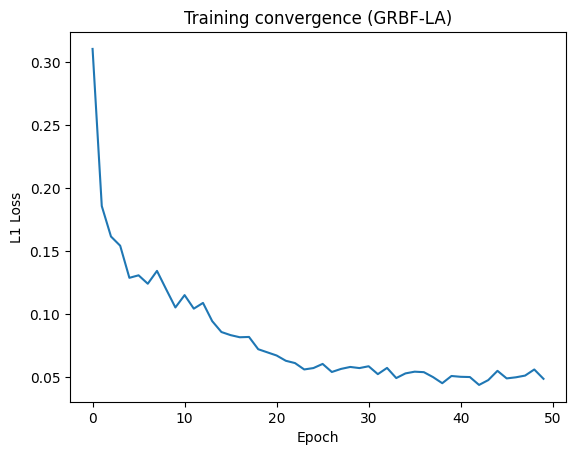

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.title("Training convergence (GRBF-LA)")
plt.show()


In [ ]:
def eval_folder(folder, scale=4, max_images=5):
    model.eval()
    psnr_list, ssim_list = [], []

    hr_dir = os.path.join(folder, "HR")
    lr_dir = os.path.join(folder, "LR_bicubic", f"X{scale}")

    files = sorted(os.listdir(hr_dir))[:max_images]

    for hr_name in files:
        hr_path = os.path.join(hr_dir, hr_name)
        lr_name = hr_name.replace(".png", f"x{scale}.png")
        lr_path = os.path.join(lr_dir, lr_name)

        hr_img = Image.open(hr_path).convert("RGB")
        lr_img = Image.open(lr_path).convert("RGB")

        lr_y = rgb_to_y(lr_img).unsqueeze(0).to(device)
        hr_y = rgb_to_y(hr_img)

        with torch.no_grad():
            sr = model(lr_y)

        sr = sr.squeeze().cpu().numpy()
        hr = hr_y.squeeze().numpy()

        # 1) Shaving
        sr = shave(sr, scale)
        hr = shave(hr, scale)

        # 2) Crop sécurisé (clé du problème)
        sr, hr = crop_to_same_size(sr, hr)

        psnr = peak_signal_noise_ratio(hr, sr, data_range=1.0)
        ssim = structural_similarity(hr, sr, data_range=1.0)

        psnr_list.append(psnr)
        ssim_list.append(ssim)

    return float(np.mean(psnr_list)), float(np.mean(ssim_list))


In [ ]:
results = {}

for name in ["Set5", "Set14", "Urban100", "B100"]:
    psnr, ssim = eval_folder(f"benchmark/{name}", scale=4, max_images=-1)
    results[name] = {"PSNR": psnr, "SSIM": ssim}
    print(f"{name}: PSNR={psnr:.2f}, SSIM={ssim:.4f}")


Set5: PSNR=24.12, SSIM=0.5981
Set14: PSNR=22.97, SSIM=0.5371
Urban100: PSNR=20.51, SSIM=0.4799
B100: PSNR=23.37, SSIM=0.5120


In [ ]:
with open("results_grbf_sr.json", "w") as f:
    json.dump(results, f, indent=2)
